# Agentic RAG

In this tutorial we will build a [retrieval agent](https://python.langchain.com/docs/tutorials/qa_chat_history). Retrieval agents are useful when you want an LLM to make a decision about whether to retrieve context from a vectorstore or respond to the user directly.

By the end of the tutorial we will have done the following:

1. Fetch and preprocess documents that will be used for retrieval.
2. Index those documents for semantic search and create a retriever tool for the agent.
3. Build an agentic RAG system that can decide when to use the retriever tool.

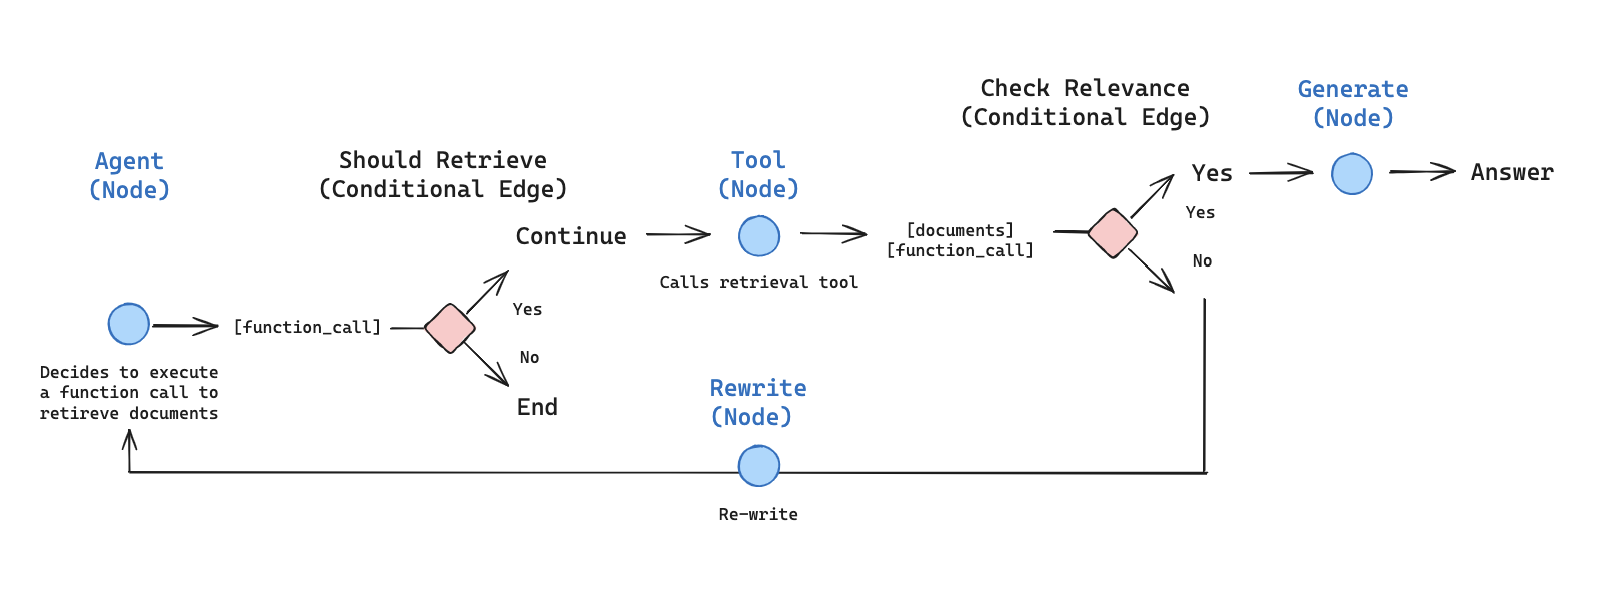

## Setup

Let's download the required packages and set our API keys:

In [1]:
%%capture --no-stderr
%pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters

In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## 1. Preprocess documents

1\. Fetch documents to use in our RAG system. We will use three of the most recent pages from [Lilian Weng's excellent blog](https://lilianweng.github.io/). We'll start by fetching the content of the pages using `WebBaseLoader` utility:

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [4]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

2\. Split the fetched documents into smaller chunks for indexing into our vectorstore:

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [6]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

## 2. Create a retriever tool

Now that we have our split documents, we can index them into a vector store that we'll use for semantic search. 

1\. Use an in-memory vector store and OpenAI embeddings:

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

2\. Create a retriever tool using LangChain's prebuilt `create_retriever_tool`:

In [8]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

3\. Test the tool:

In [9]:
retriever_tool.invoke({"query": "types of reward hacking"})

'(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nWhy does Reward Hacking Exist?#\n\nPan et al. (2022) investigated reward hacking as a function of agent capabilities, including (1) model size, (2) action space resolution, (3) observation space noise, and (4) training time. They also proposed a taxonomy of three types of misspecified proxy rewards:\n\nLet’s Define Reward Hacking#\nReward shaping in RL is challenging. Reward hacking occurs when an RL agent exploits flaws or ambiguities in the reward function to obtain high rewards without genuinely learning the intended behaviors or completing the task as designed. In recent years, several related concepts have been proposed, all referring to some form of reward hacking:'

## 3. Generate query

Now we will start building components ([nodes](../../../concepts/low_level#nodes) and [edges](../../../concepts/low_level#edges)) for our agentic RAG graph. Note that the components will operate on the [`MessagesState`](../../../concepts/low_level#messagesstate) — graph state that contains a `messages` key with a list of [chat messages](https://python.langchain.com/docs/concepts/messages/).

1\. Build a `generate_query_or_respond` node. It will call an LLM to generate a response based on the current graph state (list of messages). Given the input messages, it will decide to retrieve using the retriever tool, or respond directly to the user. Note that we're giving the chat model access to the `retriever_tool` we created earlier via `.bind_tools`:

In [10]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("openai:gpt-4.1", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        # highlight-next-line
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

2\. Try it on a random input:

In [11]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


3\. Ask a question that requires semantic search:

In [12]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_tYQxgfIlnQUDMdtAhdbXNwIM)
 Call ID: call_tYQxgfIlnQUDMdtAhdbXNwIM
  Args:
    query: types of reward hacking


## 4. Grade documents

1\. Add a [conditional edge](../../../concepts/low_level#conditional-edges) — `grade_documents` — to determine whether the retrieved documents are relevant to the question. We will use a model with a structured output schema `GradeDocuments` for document grading. The `grade_documents` function will return the name of the node to go to based on the grading decision (`generate_answer` or `rewrite_question`):

In [13]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


# highlight-next-line
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("openai:gpt-4.1", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        # highlight-next-line
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

2\. Run this with irrelevant documents in the tool response:

In [14]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

3\. Confirm that the relevant documents are classified as such:

In [15]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

## 5. Rewrite question

1\. Build the `rewrite_question` node. The retriever tool can return potentially irrelevant documents, which indicates a need to improve the original user question. To do so, we will call the `rewrite_question` node:

In [16]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

2\. Try it out:

In [17]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What are the different types of reward hacking described by Lilian Weng, and how does she explain them?


## 6. Generate an answer

1\. Build `generate_answer` node: if we pass the grader checks, we can generate the final answer based on the original question and the retrieved context:

In [18]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

2\. Try it:

In [19]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng says that reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering. These categories describe different ways in which an agent might exploit flaws in the reward system. Environment or goal misspecification involves unintended behaviors due to poorly specified objectives, while reward tampering involves directly manipulating the reward signal.


## 7. Assemble the graph

* Start with a `generate_query_or_respond` and determine if we need to call `retriever_tool`
* Route to next step using `tools_condition`:
    * If `generate_query_or_respond` returned `tool_calls`, call `retriever_tool` to retrieve context 
    * Otherwise, respond directly to the user
* Grade retrieved document content for relevance to the question (`grade_documents`) and route to next step:
    * If not relevant, rewrite the question using `rewrite_question` and then call `generate_query_or_respond` again
    * If relevant, proceed to `generate_answer` and generate final response using the `ToolMessage` with the retrieved document context

In [20]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

Visualize the graph:

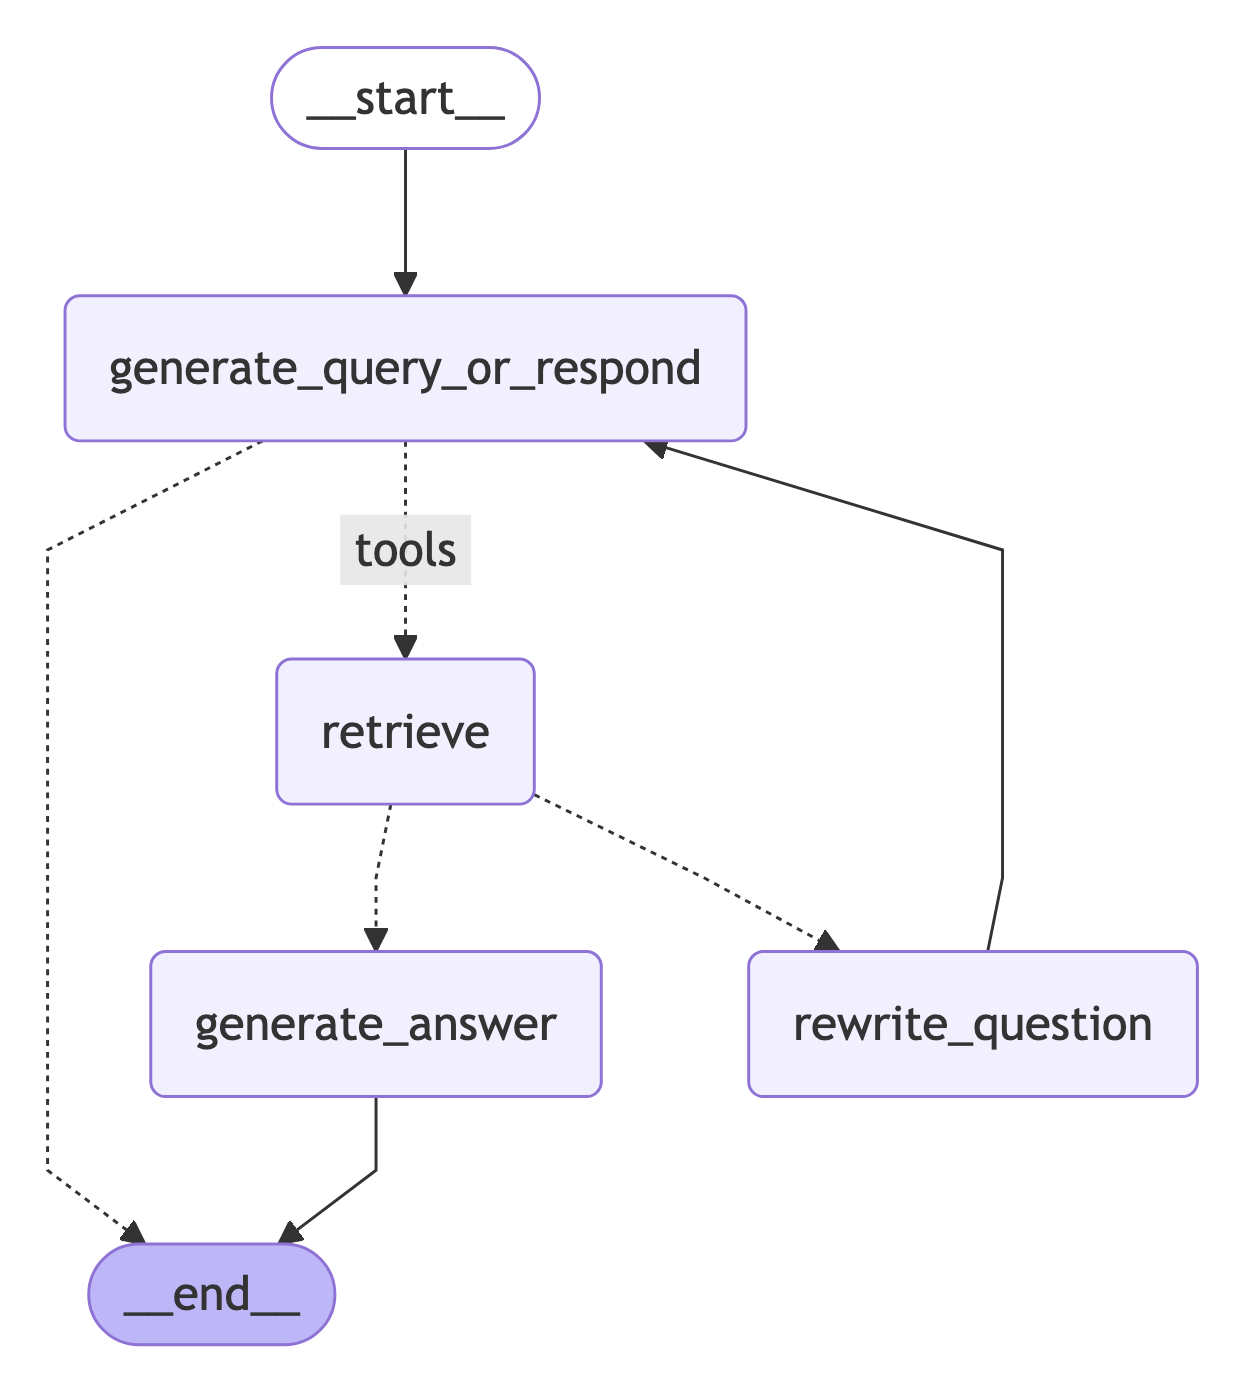

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 8. Run the agentic RAG

In [23]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_NYu2vq4km9nNNEFqJwefWKu1)
 Call ID: call_NYu2vq4km9nNNEFqJwefWKu1
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.

Why does Reward Hacking Exist?#

Pan et al. (2022) investigated reward hacking as a function of agent capabilities, including (1) model size, (2) action space resolution, (3) observation space noise, and (4) training time. They also proposed a taxonomy of three types of misspecified proxy rew